In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [2]:
%cd gdrive/My\ Drive/nlp/
!ls

/content/gdrive/My Drive/nlp
test.csv  train.csv


In [57]:
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [58]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [59]:
df_train = pd.read_csv('train.csv').fillna(' ')
df_test = pd.read_csv('test.csv').fillna(' ')

df_train.keyword = df_train.keyword.str.replace("%20", " ")
df_test.keyword = df_test.keyword.str.replace("%20", " ")


# Data preprocessing

In [60]:
df_train.text = df_train.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_test.text = df_test.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_train.text = df_train.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
df_test.text = df_test.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [61]:
def preprocess_news(df):
    stops = set(stopwords.words('english'))
    new_corpus=[]

    lem=WordNetLemmatizer()
    for text in df["text"]:
        words=[w for w in word_tokenize(text) if (w not in stops)]

        words=[lem.lemmatize(w) for w in words]

        new_corpus += words
    return set(new_corpus)

In [62]:
corpus = preprocess_news(df_train)

In [63]:
corpus #Unique words

{'Cameo',
 'typewriter',
 'Picking',
 'Spring',
 'cowardly',
 'redesigned',
 'wonderful',
 'donate',
 'navigating',
 'cuff',
 'Bahrain',
 'SIGALERT',
 'Mohammed',
 'bigconsequences',
 'COUNTY',
 'confounds',
 'Ral',
 'Classic',
 'ANGEL',
 'distinction',
 'Without',
 'Stepped',
 'Pennington',
 'mega',
 'Aidan',
 'acquired',
 '365disasters',
 'Front',
 'sponsor',
 'Pipeliners',
 'ward',
 'Wyrmwood',
 'furst',
 'Carbondale',
 'escort',
 '109',
 'Prestons',
 'stretcher',
 'batting',
 'loudest',
 'Again',
 'ABLAZE',
 'EVERYWHERE',
 'broken',
 'CASUALTY',
 'document',
 'StrategicPatience',
 'vet',
 'trans',
 'Temple',
 'Catch',
 'HHS',
 'splatoon',
 'club',
 'shud',
 'Frank',
 'Catholicism',
 'mybabies',
 'Caitlin',
 'rang',
 'artillery',
 'Residential',
 'Yup',
 'CatfishMTV',
 'quick',
 'Nieuws',
 'Forgotten',
 'wth',
 'DONE',
 'LoveFood',
 'Bland',
 'Lifted',
 'impossible',
 'PP',
 'Jerry',
 '28700',
 'Dijk',
 'Ending',
 'cabling',
 '3la',
 '513',
 'DrAyesha4',
 'Lightening',
 'climbing',


In [64]:
def preprocess(text):
    stops = set(stopwords.words('english'))

    lem=WordNetLemmatizer()

    words=[w for w in word_tokenize(text) if (w not in stops)]

    words=[lem.lemmatize(w) for w in words]
   
    return words

In [65]:
df_train.text = df_train.text.apply(lambda x: ' '.join(preprocess(x)))
df_test.text = df_test.text.apply(lambda x: ' '.join(preprocess(x)))

# EDA

## Target and not target records count

0    4342
1    3271
Name: target, dtype: int64


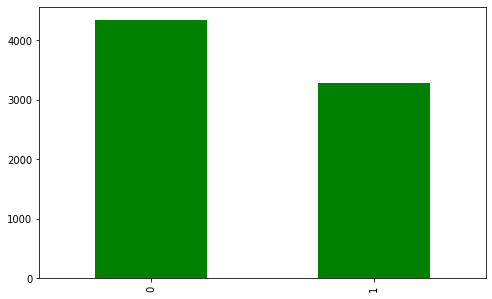

In [66]:
plt.figure(figsize=(8,5))
df_train['target'].value_counts().plot(kind='bar',color='green')
print(df_train['target'].value_counts())

## Keywords statistics

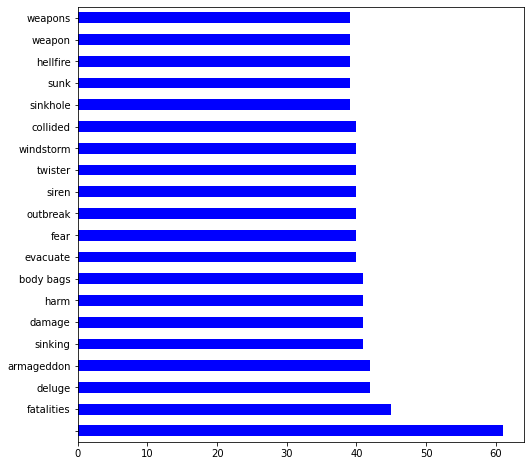

In [67]:
plt.figure(figsize=(8,8))
df_train['keyword'].value_counts()[:20].plot(kind='barh',color='blue')

## Locations statistics

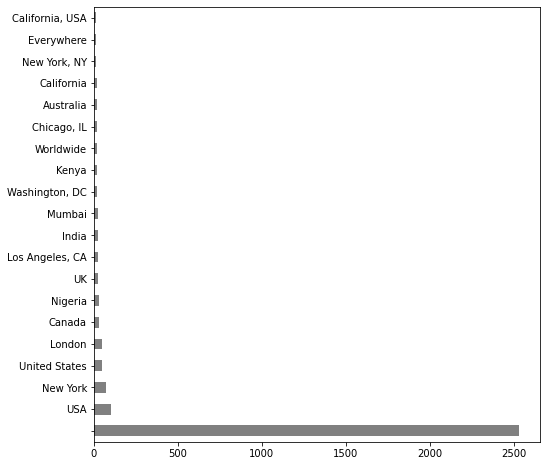

In [68]:
plt.figure(figsize=(8,8))
df_train['location'].value_counts()[:20].plot(kind='barh',color='grey')

## Disaster and Non Disaster tweets length

Text(0.5, 1.0, 'Non Disaster tweets length')

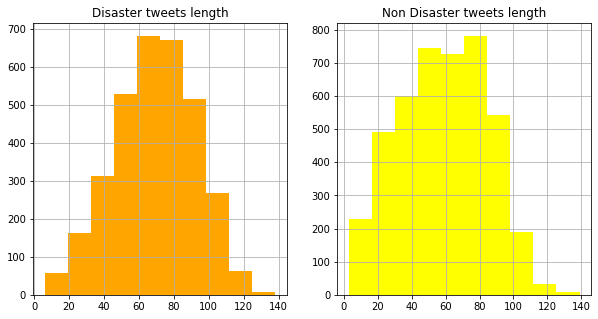

In [69]:
tweet_dis = df_train[df_train['target']==1]
tweet_ndis = df_train[df_train['target']==0]
len_dis = tweet_dis.text.str.len()
len_ndis = tweet_ndis.text.str.len()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(len_dis,color='orange')
plt.grid()
plt.title('Disaster tweets length')
plt.subplot(1,2,2)
plt.hist(len_ndis,color='yellow',)
plt.grid()
plt.title('Non Disaster tweets length')

## Disaster and Non Disaster word length

Text(0.5, 1.0, 'Non Disaster word length')

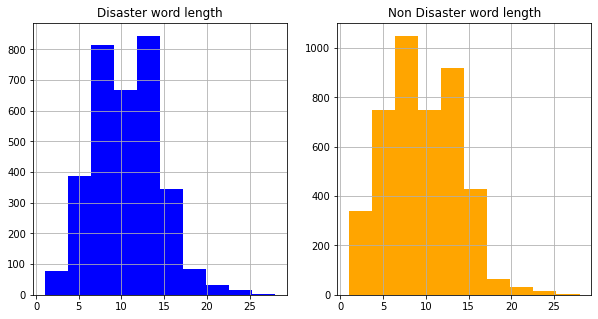

In [70]:
words_dis = df_train[df_train['target']==1]['text'].str.split().map(lambda x:len(x))
words_ndis = df_train[df_train['target']==0]['text'].str.split().map(lambda x:len(x))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(words_dis,color='blue')
plt.grid()
plt.title('Disaster word length')
plt.subplot(1,2,2)
plt.hist(words_ndis,color='orange',)
plt.grid()
plt.title('Non Disaster word length')

# Cloud of words

## Keywords

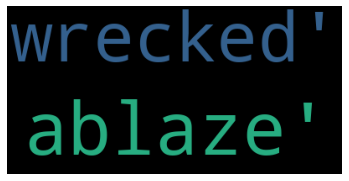

In [71]:
text = df_train.query('keyword!=" "').keyword.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Locations

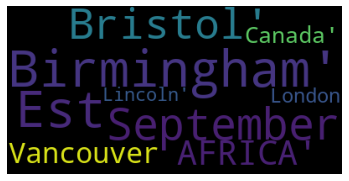

In [72]:
text = df_train.query('location!=" "').location.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Text

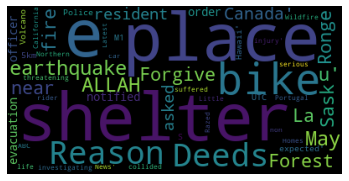

In [73]:
text = df_train.text.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# sklearn.CountVectorize

In [74]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(df_train["text"])
test_vectors = count_vectorizer.transform(df_test["text"])

In [75]:
print(train_vectors[0].todense().shape)
print(test_vectors[0].todense().shape)

train_vectors_df = pd.DataFrame(train_vectors.todense())
train_vectors_df.head()

(1, 14384)
(1, 14384)


,0,1,2,3,4,5,6,7,8,9,...,14374,14375,14376,14377,14378,14379,14380,14381,14382,14383
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
test_vectors_df = pd.DataFrame(test_vectors.todense())
test_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14374,14375,14376,14377,14378,14379,14380,14381,14382,14383
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Graphics

In [79]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(df_train.head()["text"])
test_vectors = count_vectorizer.transform(df_test.head()["text"])

train_vectors_df = pd.DataFrame(train_vectors.todense())
train_vectors_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,2,0,0
3,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,1


<Figure size 576x576 with 0 Axes>

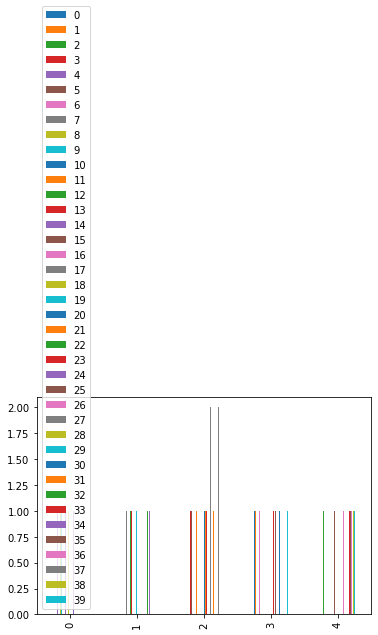

In [85]:
plt.figure(figsize=(8,8))
train_vectors_df.plot(kind='bar')

In [80]:
test_vectors_df = pd.DataFrame(test_vectors.todense())
test_vectors_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 576x576 with 0 Axes>

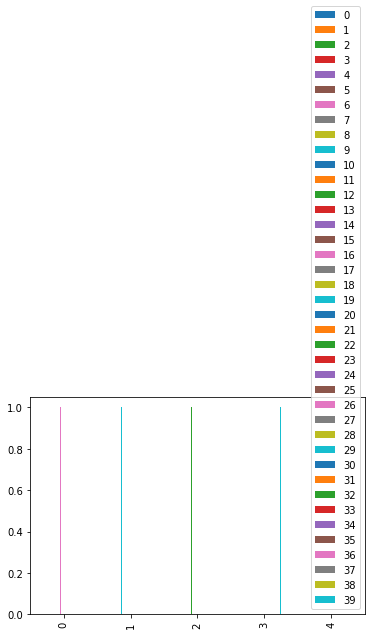

In [86]:
plt.figure(figsize=(8,8))
test_vectors_df.plot(kind='bar')

# TF-IDF

In [ ]:
train_text = df_train['text']
test_text = df_test['text']
summary_text = pd.concat([train_text, test_text])

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(summary_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(summary_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [ ]:
train_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_oof = np.zeros(df_train.shape[0],)
kf = KFold(n_splits=5, random_state=137, shuffle=True)
test_preds = 0

for jj, (train_index, val_index) in enumerate(kf.split(train_features)):
        print("Fitting fold", jj+1)
        train_x = train_features.toarray()[train_index]
        val_x = train_features.toarray()[val_index]
        train_target = df_train['target'].values[train_index]
        classifier = LogisticRegression(solver='sag')
        classifier.fit(train_x, train_target)
        train_oof[val_index] = classifier.predict_proba(val_x)[:,1]
        test_preds += classifier.predict_proba(test_features)[:,1]/5
        
print(roc_auc_score(df_train['target'].values, train_oof))

Fitting fold 1
Fitting fold 2


In [ ]:
submission =pd.read_csv('sample_submission.csv')
submission.head()

In [ ]:
submission['target'] = 1*(test_preds > 0.5)
submission.head()